# Mirror Mirror on the Wall, Who's the Spookiest of them all?

In [1]:
from all_imports import *
warnings.filterwarnings("ignore")
tqdm.pandas()
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)

In [2]:
df = initialize(df)
encoder = LabelEncoder()
df['author'] = encoder.fit_transform(df.author.values)


In [3]:
nlp = spacy.load("en_core_web_lg")

## FEATURE ENGINEERING

In [4]:
def add_features(row):
    text = row.text
    doc = nlp(text)
    lemmas = list()
    entities = list()
    for token in doc:
        if token.text == ':':
            row['has_colon'] = 1
        if token.text == ';':
            row['has_semicolon'] = 1
        if token.text == '-':
            row['has_dash'] = 1
        pos = token.pos_
        row[pos] += 1
        if token.is_stop or not token.is_alpha:
            continue
        lemma = token.lemma_.strip().lower()
        if lemma:
            lemmas.append(lemma)
    for ent in doc.ents:
        entities.append(ent.text)
    lemmas = ' '.join(lemmas)
    blob = TextBlob(text)
    row['subjectivity'] = blob.sentiment.subjectivity
    row['polarity'] = blob.sentiment.polarity
    row['starts_conj'] = int(doc[0].pos_ == 'CONJ')
    row['ends_prep'] = int(doc[0].pos_ == 'PREP')
    row['entities'] = entities
    row['lemmas'] = lemmas
    row['raw_text_length'] = len(text)
    row['num_words'] = len(doc)
    row['avg_word_len'] = row.raw_text_length / row.num_words
    row['vector_avg'] = np.mean(nlp(lemmas).vector)
    return row

df = df.apply(lambda x: add_features(x), axis=1)
df['topic'] = get_topics(df.text.values.tolist(), num_topics = 6)
dummies = pd.get_dummies(df.topic)
df = pd.concat([df, dummies], axis=1)

Text(0, 0.5, 'Sentiment (Polarity)')

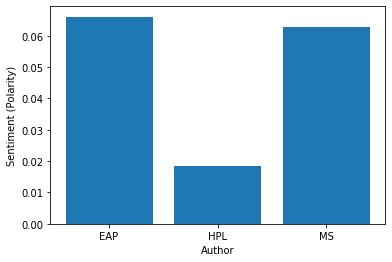

In [27]:
x = ['EAP', 'HPL', 'MS']
y = df.groupby('author').polarity.mean().values
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(x, y)
plt.xlabel('Author')
plt.ylabel('Sentiment (Polarity)')

Text(0, 0.5, 'Average # Signifant Words (No stop words)')

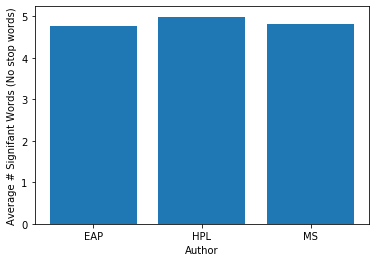

In [32]:
x = ['EAP', 'HPL', 'MS']
y = df.groupby('author').avg_word_len.mean().values
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(x, y)
plt.xlabel('Author')
plt.ylabel('Average # Signifant Words (No stop words)')

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['author', 'lemmas', 'entities'], axis=1), df.author.values, test_size=0.25, random_state=0)
cv = CountVectorizer()

cv.fit(np.concatenate([X_train.text, X_valid.text]))
X_train_cv = cv.transform(X_train.text)
X_valid_cv = cv.transform(X_valid.text)

x_train_array = pd.DataFrame(X_train_cv.toarray())
x_valid_array = pd.DataFrame(X_valid_cv.toarray())

X_train.reset_index(inplace=True)
X_valid.reset_index(inplace=True)
X_train_full = pd.concat([x_train_array, X_train], axis=1)
X_valid_full = pd.concat([x_valid_array, X_valid], axis=1)
X_train_final = X_train_full.drop(['text', 'index'], axis=1)
X_valid_final = X_valid_full.drop(['text', 'index'], axis=1)

In [6]:
for col in X_train_final.columns:
    if X_train_final[col].values.min() < 0:
        X_train_final[col] = X_train_final[col] - X_train_final[col].values.min()
        
for col in X_valid_final.columns:
    if X_valid_final[col].values.min() < 0:
        X_valid_final[col] = X_valid_final[col] - X_valid_final[col].values.min()

## MODELING

In [7]:
model = MultinomialNB(alpha=.1)
model.fit(X_train_final, y_train)
preds = model.predict(X_valid_final)
acc = accuracy_score(y_valid, preds)
print('Multinomial Naive Bayes Accuracy: ', acc)

Multinomial Naive Bayes Accuracy:  0.8506639427987742


## DEMO

In [36]:
text = input('Enter Your Sentence:\n\n')
input_df = pd.DataFrame(data={'text': text}, index=[0])
input_df = initialize(input_df)
input_df = input_df.apply(lambda x: add_features(x), axis=1)
input_df['topic'] = get_topics(input_df.text.values.tolist(), num_topics = 6)
# input_df = pd.concat([input_df, dummies], axis=1)
input_df.drop(['lemmas', 'entities'], axis=1, inplace=True)
test = pd.DataFrame(cv.transform(input_df.text).toarray())
test.reset_index(inplace=True)
test_final = pd.concat([input_df, test], axis=1)
test_final = test_final.drop(['text', 'index'], axis=1)
test_final['0'] = 0
test_final['1'] = 0
test_final['2'] = 0
test_final['3'] = 0
test_final['5'] = 0
test_final['6'] = 0
for col in test_final.columns:
    if test_final[col].values.min() < 0:
        test_final[col] = test_final[col] - test_final[col].values.min()
prediction = model.predict_proba(test_final)
author_map = {0: 'Edgar Allan Poe', 1: 'HP Lovecraft', 2: 'Mary Shelley'}


Enter Your Sentence:

lauren is a very nice person  ilove her 


In [37]:
print(prediction)

[[1.00000000e+00 9.51210326e-52 4.00836388e-58]]
